In [97]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

import numpy as np

In [98]:
def wire_order_maker(d):
    wire_order = [0, 1]
    for a in range(d - 2):
        wire_order += [a + d, a + 2]
    return wire_order

In [99]:
def left_toffoli(with_carry=False):
    qcontrol, qtarget = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt")

    gate_name = f"left-Toffoli\nwith carry" if with_carry else f"left-Toffoli"

    left_toffoli_gate = QuantumCircuit(qcontrol, qtarget, name=gate_name)

    if with_carry:
        left_toffoli_gate.cx(qcontrol[1], qtarget[0])
        left_toffoli_gate.x(qcontrol[1])
        left_toffoli_gate.cz(qcontrol[0], qcontrol[1])

    left_toffoli_gate.h(qtarget[0])
    left_toffoli_gate.t(qtarget[0])

    left_toffoli_gate.cx(qcontrol[0], qtarget[0])
    left_toffoli_gate.cx(qcontrol[1], qtarget[0])
    left_toffoli_gate.cx(qtarget[0], qcontrol[1])
    left_toffoli_gate.cx(qtarget[0], qcontrol[0])

    left_toffoli_gate.tdg(qcontrol)
    left_toffoli_gate.t(qtarget[0])

    left_toffoli_gate.cx(qtarget[0], qcontrol[0])
    left_toffoli_gate.cx(qtarget[0], qcontrol[1])

    left_toffoli_gate.h(qtarget[0])
    #right_toffoli_gate.s(qtarget[0]) # I'm doing this separately in the main circuit

    return left_toffoli_gate

def right_toffoli():
    qcontrol, qtarget, clreg = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt"), ClassicalRegister(1, "clss")

    right_toffoli_gate = QuantumCircuit(qcontrol, qtarget, clreg, name=f"right-Toffoli")

    right_toffoli_gate.h(qtarget[0])

    right_toffoli_gate.measure(qtarget[0], clreg[0])

    right_toffoli_gate.cz(qcontrol[0], qcontrol[1]).c_if(clreg[0], 1)
    right_toffoli_gate.x(qtarget[0]).c_if(clreg[0], 1)

    return right_toffoli_gate

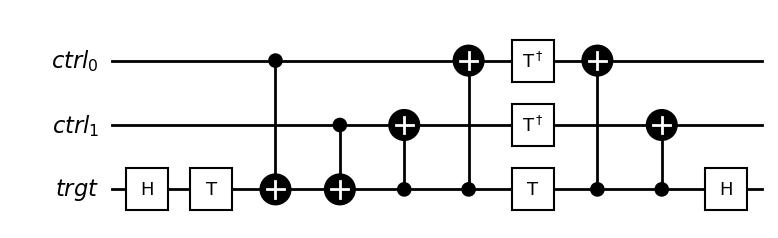

In [100]:
left_toffoli().draw(output="mpl", style="bw")

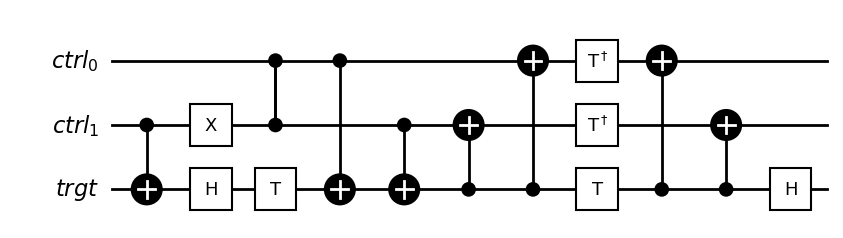

In [101]:
left_toffoli(with_carry=True).draw(output="mpl", style="bw")

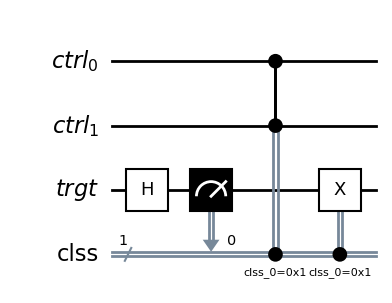

In [102]:
right_toffoli().draw(output="mpl", style="bw")

In [103]:
def quantum_shifter(k, d):
    if ((not isinstance(d, int)) or d < 1) or (not isinstance(k, int)):
        raise TypeError(f"silly you: bad input")
        return 0

    k %= 1 << d

    qregx = QuantumRegister(d, "x")
    quantum_shifter_circuit = QuantumCircuit(qregx, name=f"{d}-bit {k}-shifter")

    if d < 3: # these are Clifford
        if d == 1 and k == 1:
            quantum_shifter_circuit.x(qregx[0])
        if d == 2:
            if k == 1:
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
                quantum_shifter_circuit.x(qregx[0])
            if k == 2:
                quantum_shifter_circuit.x(qregx[1])
            if k == 3:
                quantum_shifter_circuit.x(qregx[0])
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
        return quantum_shifter_circuit

    qcarry, clreg = AncillaRegister(d - 2, "carry"), ClassicalRegister(d - 2, "c")
    quantum_shifter_circuit.add_register(qcarry, clreg)

    if k == 0:
        return quantum_shifter_circuit

    least_significant_bit = (k&-k).bit_length() - 1 # at least 0

    if least_significant_bit > 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> least_significant_bit, d - least_significant_bit), qubits=qregx[least_significant_bit:] + qcarry[least_significant_bit:], clbits=clreg[least_significant_bit:], inplace=True)
        return quantum_shifter_circuit

    if k >> (d - 2) != 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> (d - 2), 2), qubits=qregx[-2:], inplace=True)
        k %= 1 << (d - 2)

    k_middle_bits = (k >> np.arange(1, d - 1))%2

    left_toffoli_gate, left_toffoli_gate_with_carry, right_toffoli_gate = left_toffoli(), left_toffoli(with_carry=True), right_toffoli()

    if k_middle_bits[0] == 1:
        quantum_shifter_circuit.cx(qregx[0], qcarry[0])
        quantum_shifter_circuit.cx(qregx[1], qcarry[0])

    quantum_shifter_circuit.compose(left_toffoli_gate, qubits=[qregx[0], qregx[1], qcarry[0]], inplace=True)

    for idx in range(1, d - 2):
        if k_middle_bits[idx] == 1:
            quantum_shifter_circuit.compose(left_toffoli_gate_with_carry, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], inplace=True)
        else:
            quantum_shifter_circuit.compose(left_toffoli_gate, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], inplace=True)

    quantum_shifter_circuit.s(qcarry) # phase fix for the Toffolis
    quantum_shifter_circuit.cx(qcarry[- 1], qregx[- 1])

    for idx in range(d - 3, 0, - 1):
        quantum_shifter_circuit.compose(right_toffoli_gate, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], clbits=clreg[idx], inplace=True)
        quantum_shifter_circuit.cx(qcarry[idx - 1], qregx[idx + 1])

    quantum_shifter_circuit.compose(right_toffoli_gate, qubits=[qregx[0], qregx[1], qcarry[0]], clbits=clreg[0], inplace=True)

    quantum_shifter_circuit.compose(quantum_shifter(k, 2), qubits=qregx[:2], inplace=True)

    return quantum_shifter_circuit

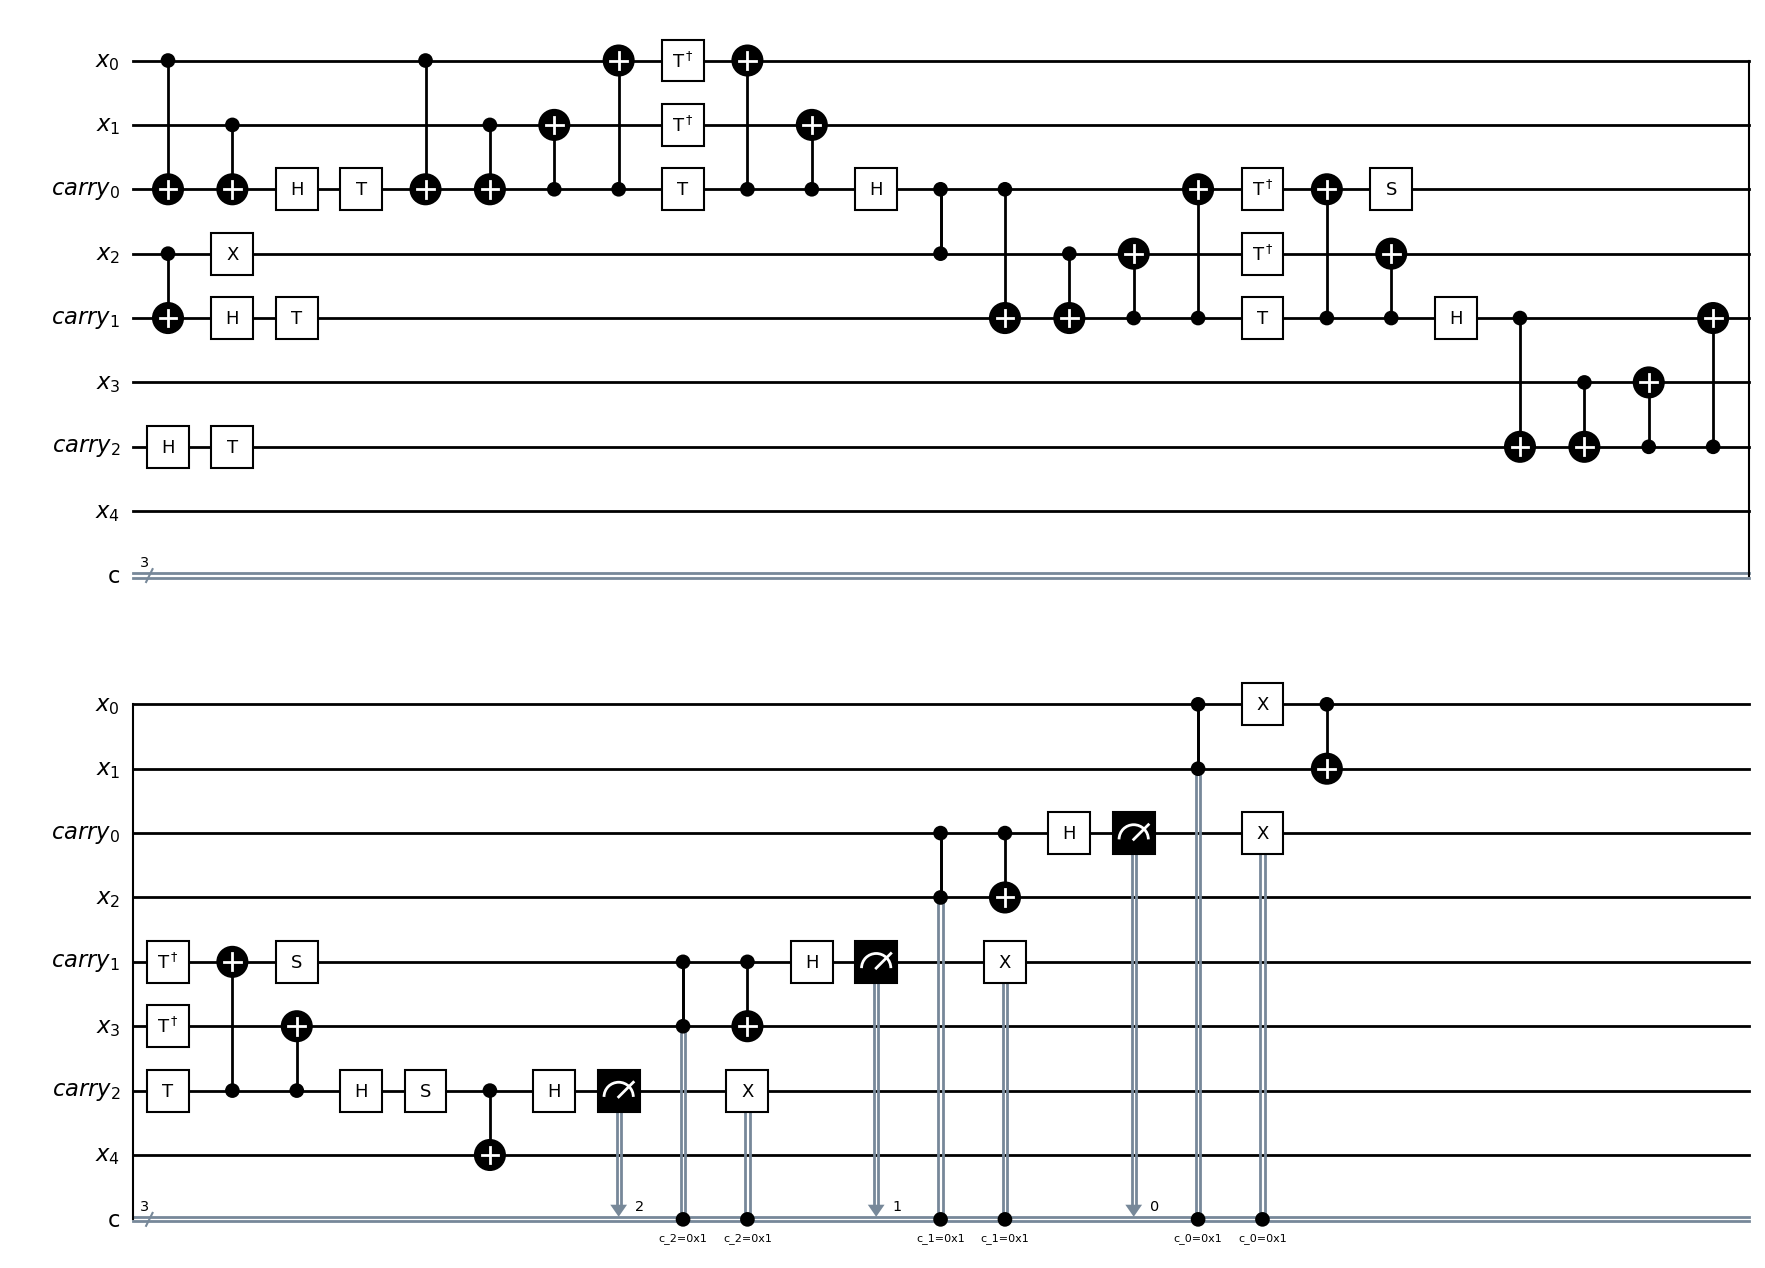

In [104]:
k, d = 7, 5
quantum_shifter(k, d).draw(output="mpl", style="bw", wire_order=wire_order_maker(d))

### Testing:

In [105]:
from qiskit import transpile
from qiskit_aer import AerSimulator

In [106]:
sim = AerSimulator()

In [109]:
k, d, x = 11, 6, 1 # addendum, number of bits, inital state

qregx = QuantumRegister(d, "q")
qcarry = AncillaRegister(d - 2, "a")
clreg = ClassicalRegister(d - 2, "c")
resreg = ClassicalRegister(d, "res") # for the final results

quantum_shifter_circuit = QuantumCircuit(qregx, qcarry, clreg, resreg, name="quantum {b}-bit {k}-shifter")

for idx, bit in enumerate((x >> np.arange(d))%2):
    if bit == 1:
        quantum_shifter_circuit.x(qregx[idx])

quantum_shifter_circuit.compose(quantum_shifter(k, d), qubits=qregx[:] + qcarry[:], clbits=clreg, inplace=True)

quantum_shifter_circuit.measure(qregx, resreg)

transpiled_circuit = transpile(quantum_shifter_circuit, backend=sim)

job = sim.run(transpiled_circuit, shots=10)

counts = job.result().get_counts()

result = int(list(counts.keys())[0][:d], 2)

if result != (x + k)%(1 << d):
    print(f"x = {x}\tk = {k}\tx + k = {(x + k)%(1 << d)} (mod 1 << {d})\tresult = {result}")
else:
    print(f"no errors!!!")

no errors!!!


In [112]:
counts.keys()

dict_keys(['001100 1001', '001100 1010', '001100 1110', '001100 1000', '001100 1011', '001100 0111', '001100 0011', '001100 1100'])